# Robotic Systems II (ECE-DK904)

## Electrical and Computer Engineering Department, University of Patras, Greece

**Instructor:** Konstantinos Chatzilygeroudis (costashatz@upatras.gr)

## Lab 1

### Double Integrator System

Our first real task is to write the `Double Integrator 1D System`:

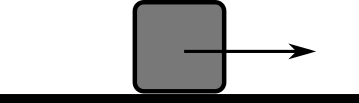

Let's remind ourselves of the equations:

$\boldsymbol{x} = \begin{bmatrix}x\\\dot{x}\end{bmatrix}, \boldsymbol{u} = K\ddot{x}$

$\dot{\boldsymbol{x}} = \begin{bmatrix}\dot{x}\\\frac{\boldsymbol{u}}{K}\end{bmatrix}$

where $K$ is the mass of the object sliding in 1D line.

We first need to import the libraries required for linear algebra (numpy, scipy) and plotting (matplotlib):

In [187]:
import numpy as np # Linear Algebra
import scipy # For matrix exponential
import matplotlib.pyplot as plt # Plotting

We then need to define a function called `di_dynamics()` that will define the dynamics of our Double Integrator system. In essence the function should take as input $\boldsymbol{x}, \boldsymbol{u}$ and output $\dot{\boldsymbol{x}}$:

In [190]:
def di_dynamics(x, u):
    K = 1.
    ### TO-DO: Implement x_dot! ###
    v = x[1]
    u = u[0]
    x_dot = np.block([[v], [u/K]])
    ### END TO-DO ###
    return x_dot

Now let's test our function to see if we have done a good job:

In [191]:
x0 = np.array([[0., 0.]]).T # We start at x=0, v=0
u = np.array([[1.]]) # Let's apply a force of 1N

print(di_dynamics(x0, u)) # We should see [0. 1.]^T as an output

[[0.]
 [1.]]


Let's try another one:

In [192]:
x0 = np.array([[0., 1.]]).T # We start at x=0, v=1
u = np.array([[-2.]]) # Let's apply a force of -2N

print(di_dynamics(x0, u)) # We should see [1. -2.]^T as an output

[[ 1.]
 [-2.]]


### Pendulum System

Nice! Let's try something more complicated now. The pendulum:

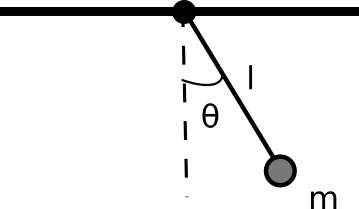

$\boldsymbol{x} = \begin{bmatrix}\theta\\\dot{\theta}\end{bmatrix}$

$\boldsymbol{u} = \tau\in\mathbb{R}$

$\dot{\boldsymbol{x}} = \begin{bmatrix}\dot{\theta}\\\frac{-g}{l}\text{sin}\theta+\frac{1}{ml^2}\boldsymbol{u}\end{bmatrix}$

where $g$ is the gravity, $l$ is the length of the pendulum pole and $m$ is the mass of the tip of the pole. Let's create a function `pendulum_dynamics()` that calculates the dynamics of the pendulum:

In [193]:
def pendulum_dynamics(x, u):
    g = 9.81
    l = 1.
    m = 1.
    ### TO-DO: Implement x_dot! ###
    theta = x[0,0]
    theta_dot = x[1,0]
    x_dot = np.block([[theta_dot], [-g/l*np.sin(theta) + (1/(m*(l**2))) * u]])
    ### END TO-DO ###
    return x_dot

Let's test it as well!

In [194]:
x0 = np.array([[0., 0.]]).T # We start at θ=0, $\dot{θ}$=0
u = np.array([[1.]]) # Let's apply a torque of 1Nm

print(pendulum_dynamics(x0, u)) # We should see [0. 1.]^T as an output

[[0.]
 [1.]]


In [195]:
x0 = np.array([[np.pi / 2., 1.]]).T # We start at θ=π/2, $\dot{θ}$=1.
u = np.array([[-2.5]]) # Let's apply a torque of -2.5Nm

print(pendulum_dynamics(x0, u)) # We should see [1. -12.31^T as an output

[[  1.  ]
 [-12.31]]


### Discretization with Euler Integration

The simplest integration scheme is the **Forward Euler Integration**:

$\boldsymbol{x}_{k+1} = \boldsymbol{x}_k + f(\boldsymbol{x}_k, \boldsymbol{u}_k)dt$

where $f(\cdot,\cdot)$ is the continuous time dynamics and $dt$ is the time step of integration.

Let's create a function that integrates using Euler the pendulum dynamics. We can call it `pendulum_euler()`:

In [196]:
def pendulum_euler(x, u, dt = 0.05):
    ### TO-DO: Implement x_n! ###
    x_n = x + pendulum_dynamics(x,u) * dt
    ### END TO-DO ###
    return x_n

Let's test test test:

In [197]:
x0 = np.array([[np.pi / 2., 1.]]).T # We start at θ=π/2, $\dot{θ}$=1.
u = np.array([[-2.5]]) # Let's apply a torque of -2.5Nm

print(pendulum_euler(x0, u)) # It should give [1.62079633 0.3845]^T

[[1.62079633]
 [0.3845    ]]


Let's try a full simulation of the **uncontrolled pendulum** (i.e. the version where we do not have access to $\boldsymbol{u}$):

In [198]:
x = np.array([[0.1, 0.]]).T # We start at θ=0.1, $\dot{θ}$=0
u = np.array([[0.]]) ### TO-DO: What value should we put for the uncontrolled version?

tf = 10. # total time
dt = 0.05 # time step
K = round(tf/dt) + 1 # number of steps
print("K =", K)

# We do a "rollout"
xs = [np.copy(x)]
for k in range(K):
    x = pendulum_euler(x, u, dt)
    xs.append(np.copy(x))
xs = np.array(xs)

K = 201


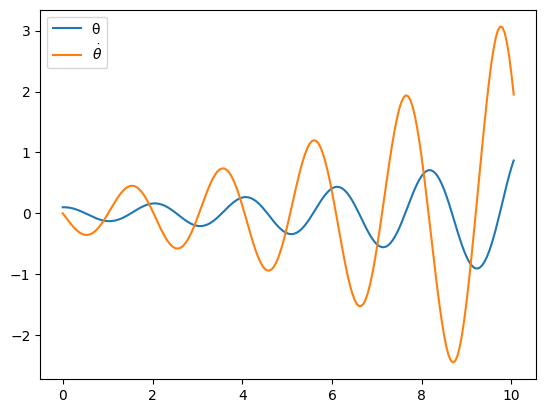

In [199]:
# Let's plot it!
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([k*dt for k in range(K+1)], xs[:,0], label='θ')
ax.plot([k*dt for k in range(K+1)], xs[:,1], label='$\dot{θ}$')

ax.legend()

plt.show()

The simulation diverges! *We can fix it a bit by using a smaller timestep*. Go back and try a few!

### Semi-Implicit Euler Integration

Let's try a better integrator. The Semi-Implicit Euler:

$\begin{bmatrix}\dot{\boldsymbol{q}}_k\\\dot{\boldsymbol{v}}_k\end{bmatrix} = f(\boldsymbol{x}_k, \boldsymbol{u}_k)$

$\boldsymbol{v}_{k+1} = \boldsymbol{v}_k + \dot{\boldsymbol{v}}_kdt$

$\boldsymbol{q}_{k+1} = \boldsymbol{q}_k + \boldsymbol{v}_{k+1}dt$

We basically compute the $\boldsymbol{v}_{k+1}$ and use that to update the *position part* of the state. Let's create a function named `pendulum_semi()` that does that:

In [200]:
def pendulum_semi(x, u, dt = 0.05):
    ### TO-DO: Implement x_n! ###
    f = pendulum_dynamics(x,u)
    q_dot = f[0,0]
    v_dot = f[1,0]

    q = x[0,0]
    v = x[1,0]
    
    v_n = v + v_dot * dt
    q_n = q + v_n * dt
    x_n = np.block([[q_n], [v_n]])
    ### END TO-DO ###
    return x_n

In [201]:
# Let's do the same simulation!
x = np.array([[0.1, 0.]]).T # We start at θ=0.1, $\dot{θ}$=0
u = np.array([[0.]]) ### TO-DO: What value should we put for the uncontrolled version?

tf = 10. # total time
dt = 0.05 # time step
K = round(tf/dt) + 1 # number of steps
print("K =", K)

# We do a "rollout"
xs = [np.copy(x)]
for k in range(K):
    x = pendulum_semi(x, u, dt)
    xs.append(np.copy(x))
xs = np.array(xs)

K = 201


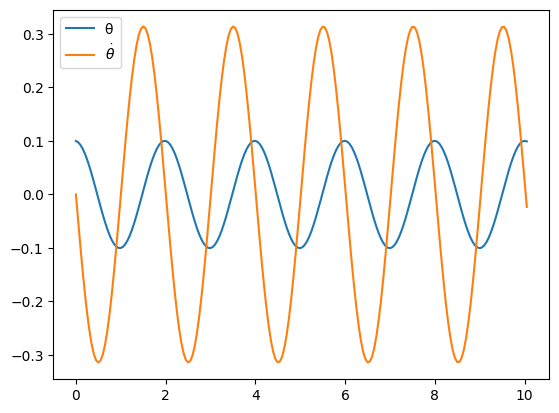

In [202]:
# Let's plot it!
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([k*dt for k in range(K+1)], xs[:,0], label='θ')
ax.plot([k*dt for k in range(K+1)], xs[:,1], label='$\dot{θ}$')

ax.legend()

plt.show()

Now this is much better! Let's try bigger horizons! It doesn't break! Which is coool!

### 4th Order Runge Kutta Integration

During the lecture we saw one more higher order integrator. The 4th Order Runge Kutta Integration or **RK4**:

$\boldsymbol{f}_1 = f(\boldsymbol{x}_k, \boldsymbol{u}_k)$

$\boldsymbol{f}_2 = f(\boldsymbol{x}_k + \boldsymbol{f}_1\frac{dt}{2}, \boldsymbol{u}_k)$

$\boldsymbol{f}_3 = f(\boldsymbol{x}_k + \boldsymbol{f}_2\frac{dt}{2}, \boldsymbol{u}_k)$

$\boldsymbol{f}_4 = f(\boldsymbol{x}_k + \boldsymbol{f}_3dt, \boldsymbol{u}_k)$

$\boldsymbol{x}_{k+1} = x + \frac{dt}{6}\Big(\boldsymbol{f}_1 + 2\boldsymbol{f}_2 + 2\boldsymbol{f}_3 + \boldsymbol{f}_4\Big)$

Let's implement it in a function called `pendulum_rk4()`:

In [203]:
def pendulum_rk4(x, u, dt = 0.05):
    ### TO-DO: Implement x_n! ###
    f1 = pendulum_dynamics(x,u)
    f2 = pendulum_dynamics(x+f1*dt/2,u)
    f3 = pendulum_dynamics(x+f2*dt/2,u)
    f4 = pendulum_dynamics(x+f3*dt,u)
    x_n = x + dt/6 * (f1 + 2*f2 + 2*f3 + f4)
    ### END TO-DO ###
    return x_n

In [204]:
# Let's do the same simulation!
x = np.array([[0.1, 0.]]).T # We start at θ=0.1, $\dot{θ}$=0
u = np.array([[0.]]) ### TO-DO: What value should we put for the uncontrolled version?

tf = 10. # total time
dt = 0.05 # time step
K = round(tf/dt) + 1 # number of steps
print("K =", K)

# We do a "rollout"
xs = [np.copy(x)]
for k in range(K):
    x = pendulum_rk4(x, u, dt)
    xs.append(np.copy(x))
xs = np.array(xs)

K = 201


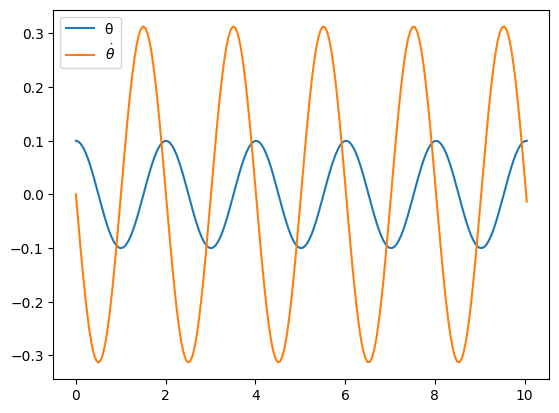

In [205]:
# Let's plot it!
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([k*dt for k in range(K+1)], xs[:,0], label='θ')
ax.plot([k*dt for k in range(K+1)], xs[:,1], label='$\dot{θ}$')

ax.legend()

plt.show()

This is coool! Play around with different horizons, timesteps. Maybe add some controls?

### Exact Discretization of Linear Systems

Our *Double Integrator* system is a linear and control affine system! We learned at the first lecture that we can discretize those systems exactly!

So first let's remind ourselves that a linear and control affine system has the following form:

$\dot{\boldsymbol{x}} = \boldsymbol{A}\boldsymbol{x} + \boldsymbol{B}\boldsymbol{u}$

Let's write the $\boldsymbol{A}$ and $\boldsymbol{B}$ matrices for our double integrator system:

In [209]:
K = 1. # the mass of the object

A = np.array([[0, 1], [0, 0]]) ### TO-DO: Create the A matrix
B = np.array([[0], [1/K]]) ### TO-DO: Create the B matrix

print("A =", A.shape) # Should be a 2x2 matrix
print("B =", B.shape) # Should be a 2x1 matrix

A = (2, 2)
B = (2, 1)


In [210]:
# Let's test it!
x0 = np.array([[0.], [0.]]) # We start at x=0, v=0
u = np.array([[1.]]) # Let's apply a force of 1N

print("func:\n", di_dynamics(x0, u)) # We should see [0. 1.]^T as an output
print("matr:\n", A@x0 + B@u) # We should see the same as abhere is the gravity, is the length of the pendulum pole and is the mass of the tip of the pole. Let's create a function pendulum_dynamics() that calculates thove

func:
 [[0.]
 [1.]]
matr:
 [[0.]
 [1.]]


Let's discretize the system via the matrix exponential. Let's remind ourselves of the equations:

$\begin{bmatrix}\boldsymbol{A}_d & \boldsymbol{B}_d\\\boldsymbol{0} & \boldsymbol{I}\end{bmatrix} = e^{\begin{bmatrix}\boldsymbol{A} & \boldsymbol{B}\\\boldsymbol{0} & \boldsymbol{0}\end{bmatrix}dt}$

where $\begin{bmatrix}\boldsymbol{A} & \boldsymbol{B}\\\boldsymbol{0} & \boldsymbol{0}\end{bmatrix}$ is a **square matrix**.

In [211]:
# Compute Ad, Bd
dt = 0.05

### TO-DO: Use `scipy.linalg.expm` to compute Ad and Bd ###
M = np.block([[A, B], [np.array([[0, 0]]), np.array([[0]])]])
expM = scipy.linalg.expm(M)
Ad = expM[0:2,0:2]
Bd = expM[0:2,2].reshape((2,1))
### END TO-DO ####

print("Ad:\n", Ad)
print("Bd:\n", Bd)

Ad:
 [[1. 1.]
 [0. 1.]]
Bd:
 [[0.5]
 [1. ]]


Let's also quickly create an RK4 integration function for the double integrator:

In [212]:
def di_rk4(x, u, dt = 0.05):
    ### TO-DO: Implement x_n! ###
    f1 = di_dynamics(x,u)
    f2 = di_dynamics(x+f1*dt/2,u)
    f3 = di_dynamics(x+f2*dt/2,u)
    f4 = di_dynamics(x+f3*dt,u)
    x_n = x + dt/6 * (f1 + 2*f2 + 2*f3 + f4)
    ### END TO-DO ###
    return x_n

In [213]:
# Let's compare the two!
x0 = np.array([[0.], [0.]]) # We start at x=0, v=0
u = np.array([[1.]]) # Let's apply a force of 1N

xn_rk4 = di_rk4(x0, u, dt)
xn = Ad@x0 + Bd@u

print("RK4:\n", xn_rk4)
print("Exp:\n", xn)
print("Difference:", np.linalg.norm(xn - xn_rk4)) # This should be zero!!

RK4:
 [[0.00125]
 [0.05   ]]
Exp:
 [[0.5]
 [1. ]]
Difference: 1.0729639148172692
